In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
ct2011 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2011_smd_hourly.xls")
ct2011 = pd.read_excel(ct2011, 'CT')
ct2012 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2012_smd_hourly.xls")
ct2012 = pd.read_excel(ct2012, 'CT')
ct2013 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2013_smd_hourly.xls")
ct2013 = pd.read_excel(ct2013, 'CT')
ct2014 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2014_smd_hourly.xls")
ct2014 = pd.read_excel(ct2014, 'CT')
ct2015 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2015_smd_hourly.xls")
ct2015 = pd.read_excel(ct2015, 'CT')
ct2016 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2016_smd_hourly.xls")
ct2016 = pd.read_excel(ct2016, 'CT')

In [3]:
ct2017 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2017_smd_hourly.xlsx", 'CT')
ct2018 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2018_smd_hourly.xlsx", 'CT')
ct2019 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2019_smd_hourly.xlsx", 'CT')
ct2020 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2020_smd_hourly.xlsx", 'CT')
ct2021 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2021_smd_hourly.xlsx", 'CT')
ct2022 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2022_smd_hourly.xlsx", 'CT')

In [10]:
ct2022

,Date,Hr_End,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point
0,2022-01-01,1,2675.9,2461.367,30.71,32.35,-0.54,-1.10,25.26,25.95,0.0,-0.69,48,46
1,2022-01-01,2,2570.2,2336.520,30.45,32.31,-0.67,-1.19,25.11,25.87,0.0,-0.76,48,46
2,2022-01-01,3,2397.1,2247.378,29.67,30.85,0.00,-1.18,26.65,27.50,0.0,-0.85,47,46
3,2022-01-01,4,2332.6,2192.153,28.59,29.69,0.00,-1.10,24.34,25.13,0.0,-0.79,47,46
4,2022-01-01,5,2316.5,2179.424,29.66,30.86,0.00,-1.20,28.30,29.27,0.0,-0.97,47,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2022-01-31,20,4377.4,4402.159,223.75,226.40,0.00,-2.65,291.87,295.80,0.0,-3.93,21,3
740,2022-01-31,21,4239.4,4264.642,200.92,202.82,0.00,-1.90,261.21,264.21,0.0,-3.00,18,4
741,2022-01-31,22,3973.5,4067.704,182.19,183.42,0.00,-1.23,249.44,251.93,0.0,-2.49,14,4
742,2022-01-31,23,3702.2,3787.636,178.46,179.93,0.00,-1.47,190.19,190.96,0.0,-0.77,15,3


In [11]:
val2011 = ct2011['DEMAND']
val2012 = ct2012['DEMAND']
val2013 = ct2013['DEMAND']
val2014 = ct2014['DEMAND']
val2015 = ct2015['DEMAND']
val2016 = ct2016['RT_Demand']
val2017 = ct2017['RT_Demand']
val2018 = ct2018['RT_Demand']
val2019 = ct2019['RT_Demand']
val2020 = ct2020['RT_Demand']
val2021 = ct2021['RT_Demand']
val2022 = ct2022['RT_Demand']

In [12]:
values = [val2011, val2012, val2013, val2014, val2015, val2016, val2017, val2018, val2019, val2020, val2021, val2022]
values_df = pd.concat(values, axis=0, ignore_index=False)
values_df = values_df.reset_index()
period = len(values_df)

In [13]:
rng = pd.date_range('2011-01-01', periods=period, freq='1H')
date_df = pd.DataFrame({ 'ds': rng})
date_df = date_df.reset_index()

In [14]:
frames = [date_df, values_df]
ct_load = pd.concat(frames, axis=1, ignore_index=False)
ct_load = ct_load.rename(columns={ct_load.columns[1]: 'ds', ct_load.columns[3]: 'y'})
frames2 = [ct_load['ds'], ct_load['y']]
ct_load = pd.concat(frames2, axis=1, ignore_index=False)
ct_load

,ds,y
0,2011-01-01 00:00:00,3053.000
1,2011-01-01 01:00:00,2892.000
2,2011-01-01 02:00:00,2774.000
3,2011-01-01 03:00:00,2710.000
4,2011-01-01 04:00:00,2698.000
...,...,...
97171,2022-01-31 19:00:00,4402.159
97172,2022-01-31 20:00:00,4264.642
97173,2022-01-31 21:00:00,4067.704
97174,2022-01-31 22:00:00,3787.636


In [15]:
model = Prophet(
        changepoint_prior_scale=0.5, 
        seasonality_mode='multiplicative', 
        interval_width=0.95, 
    )
model.add_country_holidays(country_name='US')

In [16]:
model.fit(ct_load)

In [17]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('ct_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

#with open('serialized_model.json', 'r') as fin:
    #m = model_from_json(json.load(fin))  # Load model

# Forecasting

In [11]:
future_pd = model.make_future_dataframe(
        periods=365, 
        freq='D',
        include_history=True
    )
    
# make predictions
forecast_pd = model.predict(future_pd)

In [12]:
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
97536,2022-02-16 00:00:00,2965.697944,2178.989255,3683.508085
97537,2022-02-16 01:00:00,2814.227948,2070.661236,3554.947083
97538,2022-02-16 02:00:00,2724.002501,1927.141231,3466.096440
97539,2022-02-16 03:00:00,2706.623871,1969.945282,3552.720540
97540,2022-02-16 04:00:00,2781.840752,1940.953899,3502.704911


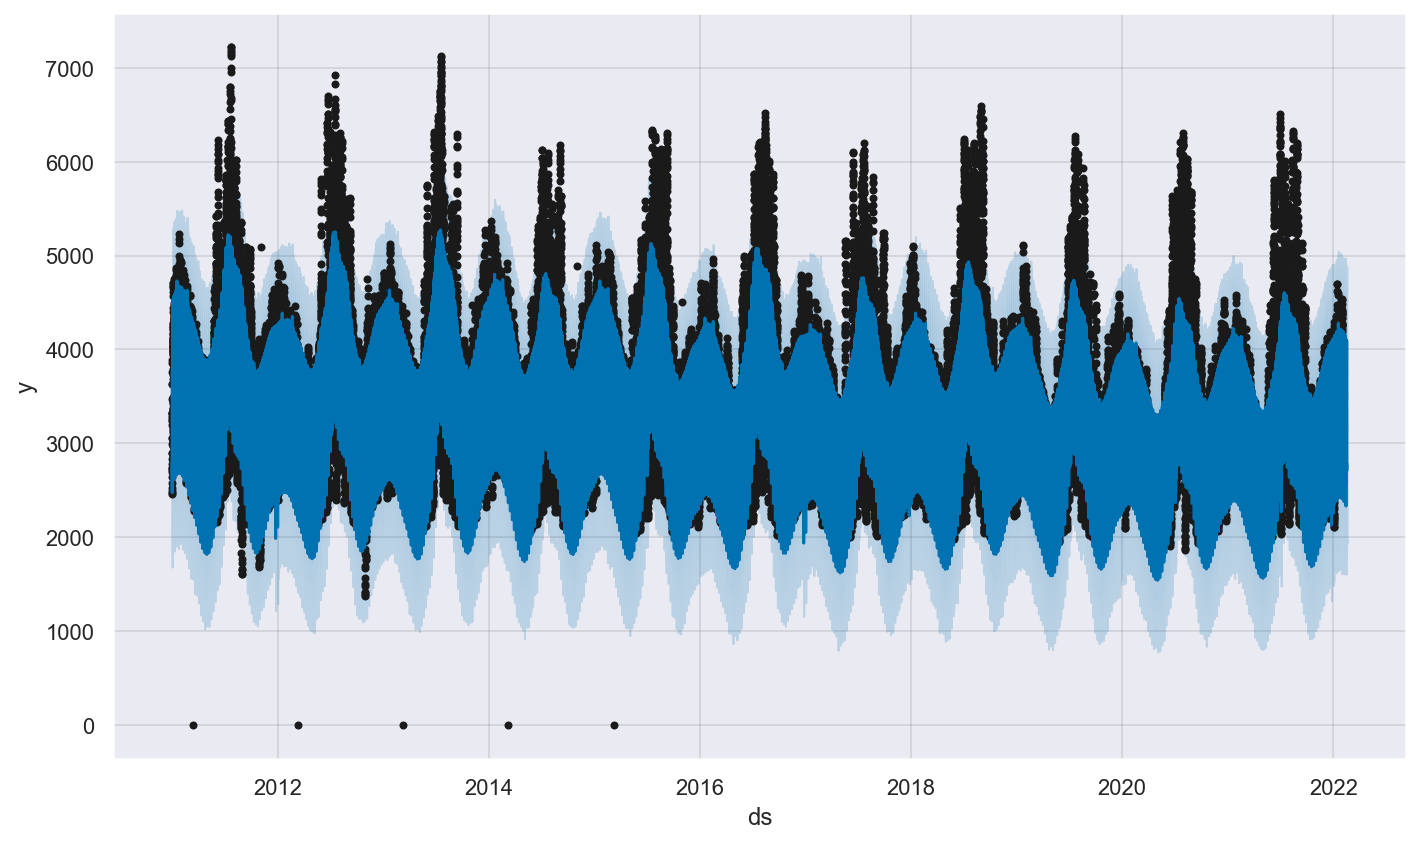

In [13]:
fig1 = model.plot(forecast_pd)

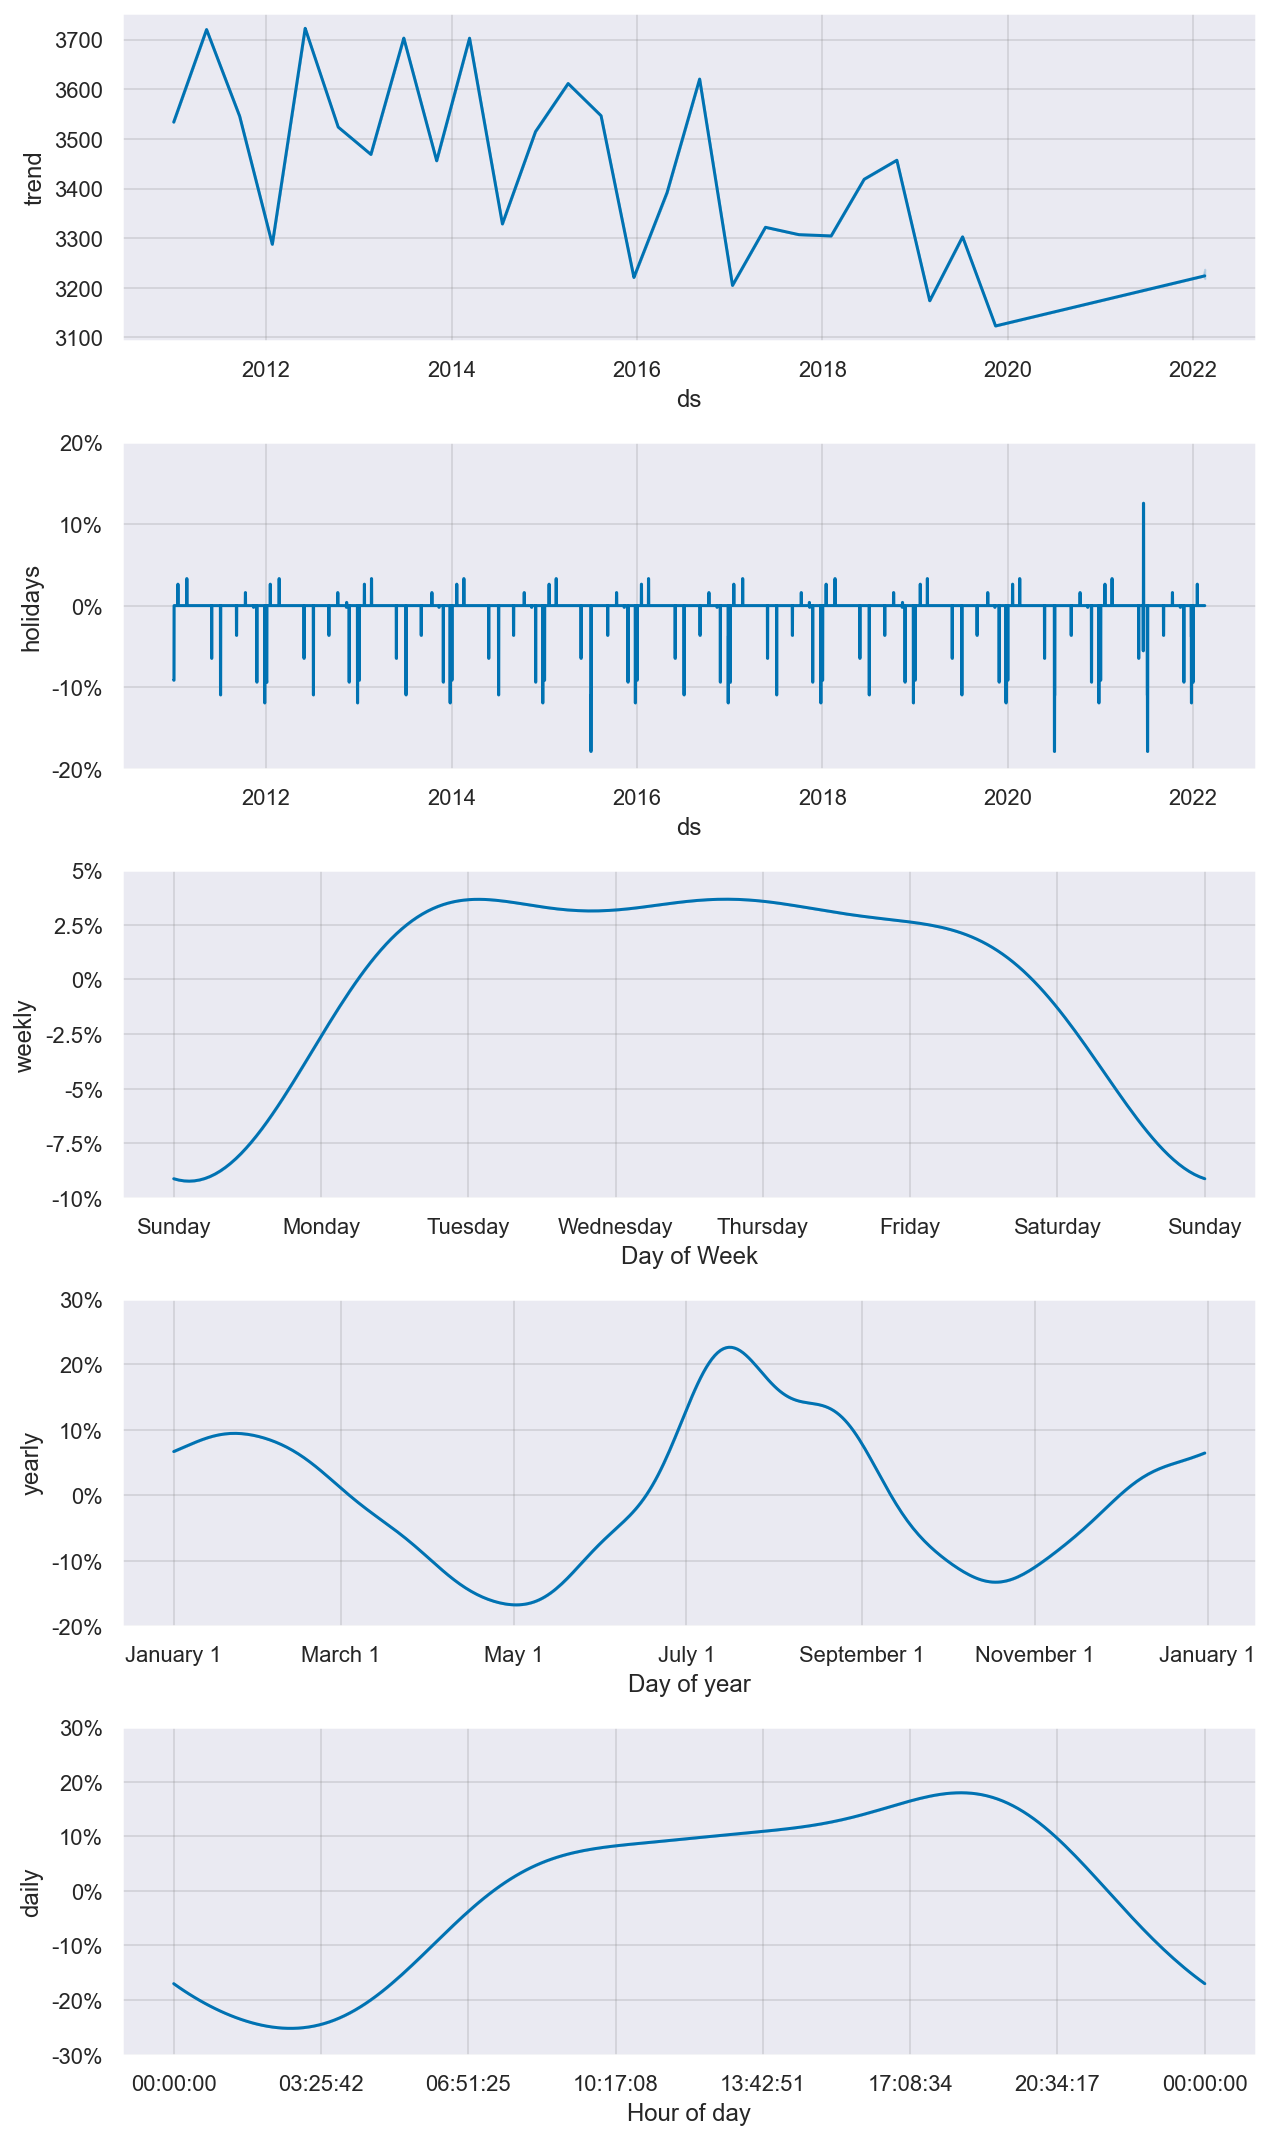

In [14]:
fig2 = model.plot_components(forecast_pd)

In [15]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01 00:00:00,3533.640238,2038.874394,3575.975500,3533.640238,3533.640238,0.0,0.0,0.0,0.0,...,-0.013107,-0.013107,-0.013107,0.065751,0.065751,0.065751,0.0,0.0,0.0,2796.977852
1,2011-01-01 01:00:00,3533.700184,1878.305674,3422.933806,3533.700184,3533.700184,0.0,0.0,0.0,0.0,...,-0.016672,-0.016672,-0.016672,0.065825,0.065825,0.065825,0.0,0.0,0.0,2618.271812
2,2011-01-01 02:00:00,3533.760130,1739.572143,3274.661429,3533.760130,3533.760130,0.0,0.0,0.0,0.0,...,-0.020362,-0.020362,-0.020362,0.065899,0.065899,0.065899,0.0,0.0,0.0,2506.095916
3,2011-01-01 03:00:00,3533.820076,1679.270879,3180.964512,3533.820076,3533.820076,0.0,0.0,0.0,0.0,...,-0.024164,-0.024164,-0.024164,0.065973,0.065973,0.065973,0.0,0.0,0.0,2473.245749
4,2011-01-01 04:00:00,3533.880021,1828.270751,3269.254868,3533.880021,3533.880021,0.0,0.0,0.0,0.0,...,-0.028061,-0.028061,-0.028061,0.066047,0.066047,0.066047,0.0,0.0,0.0,2541.454901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97536,2022-02-16 00:00:00,3224.075259,2178.989255,3683.508085,3218.849767,3237.176526,0.0,0.0,0.0,0.0,...,0.031827,0.031827,0.031827,0.058012,0.058012,0.058012,0.0,0.0,0.0,2965.697944
97537,2022-02-16 01:00:00,3224.080356,2070.661236,3554.947083,3218.773419,3237.271148,0.0,0.0,0.0,0.0,...,0.032064,0.032064,0.032064,0.057887,0.057887,0.057887,0.0,0.0,0.0,2814.227948
97538,2022-02-16 02:00:00,3224.085453,1927.141231,3466.096440,3218.697072,3237.365771,0.0,0.0,0.0,0.0,...,0.032343,0.032343,0.032343,0.057762,0.057762,0.057762,0.0,0.0,0.0,2724.002501
97539,2022-02-16 03:00:00,3224.090551,1969.945282,3552.720540,3218.620724,3237.460393,0.0,0.0,0.0,0.0,...,0.032656,0.032656,0.032656,0.057637,0.057637,0.057637,0.0,0.0,0.0,2706.623871


In [17]:
forecast_pd.to_csv('ct_forecast.csv', index=False)

In [19]:
import pickle
import joblib
 
# Save the model as a pickle in a file
joblib.dump(model, 'ct_model.pkl')

['ct_model.pkl']